In [83]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

In [84]:
data_up = pd.read_csv('../data/all_risk_processed.csv', index_col=0)

In [86]:
data_up[data_up['spinal_risk_score'] > 0.8].filter(regex="work|exer|spinal")

,exer_50improv_1drop,exer_50improv_10drop,exer_50improv_50drop,exer_50improv_90drop,exer_90improv_1drop,exer_90improv_10drop,exer_90improv_50drop,exer_90improv_90drop,exer_50pain_1death,exer_50pain_10death,...,work_90improv_10para,work_90improv_50para,work_50improv_1death,work_50improv_10death,work_50improv_50death,work_90improv_1death,work_90improv_10death,work_90improv_50death,spinal_risk_score,old_spinal_risk_score


In [87]:
data_up.head()

,record_id,risk_1_timestamp,age,sex,height,weight,zipcode,ethnicity,income,education,...,province_code,latitude,longitude,fips,GISJOIN,FIPS,ADI_NATRANK,ADI_STATERNK,spinal_risk_score,old_spinal_risk_score
0,3,1/26/2024 22:04,25,1,18,36,76177,4,4,6,...,439.0,32.9448,-97.3124,4.843911e+11,G48043901139401,4.843911e+11,34,2,0.095803,0.850389
1,6,1/26/2024 22:04,28,1,25,77,32226,4,13,6,...,31.0,30.4735,-81.5448,1.203101e+11,G12003100101071,1.203101e+11,55,6,0.161863,0.740909
2,22,1/26/2024 22:04,20,2,16,25,28729,4,11,6,...,89.0,35.3172,-82.5977,3.708993e+11,G37008909307033,3.708993e+11,47,3,0.188501,0.426640
3,4,1/26/2024 22:04,31,1,23,131,94041,5,6,7,...,85.0,37.3893,-122.0783,6.085510e+10,G06008505096003,6.085510e+10,1,1,0.148907,0.511215
4,21,1/26/2024 22:04,25,1,26,106,50010,2,4,7,...,169.0,42.0379,-93.6003,1.916900e+11,G19016900001011,1.916900e+11,30,1,0.044608,0.830583


<Axes: xlabel='dospert_health/safety', ylabel='spinal_risk_score'>

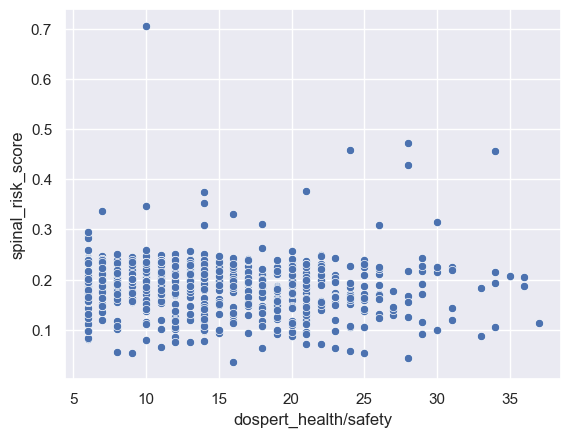

In [88]:
sns.scatterplot(x=data_up['dospert_health/safety'], y=data_up.spinal_risk_score)

In [89]:
data = pd.read_csv("../data/ml_data_processed_final.csv")
data

,ohe__religion_10,cat__sex,cat__income,cat__education,cat__prior_surg,cat__succ_surg,num__age,num__odi_final,num__bmi,num__dospert_ethical,num__dospert_financial,num__dospert_health/safety,num__dospert_recreational,num__dospert_social,num__height_m,num__weight_kg,num__ADI_NATRANK,num__ADI_STATERNK,spinal_risk_score
0,0.0,1.0,4.0,6.0,1.0,1.0,-1.451225,-0.841732,-0.995194,0.634665,1.035893,1.066906,2.797536,1.174613,-0.551831,-1.100657,-0.450926,-1.118717,0.095803
1,0.0,1.0,13.0,6.0,1.0,1.0,-1.298420,-0.705424,-0.731667,1.253831,0.375335,1.372995,1.560247,1.480169,1.178208,-0.223692,0.320327,0.337068,0.161863
2,1.0,2.0,11.0,6.0,1.0,1.0,-1.705898,-0.978040,-1.087988,-0.397279,-1.441197,-1.075717,-1.051807,-0.811502,-1.046128,-1.335940,0.026517,-0.754771,0.188501
3,0.0,1.0,6.0,7.0,1.0,1.0,-1.145616,-0.296500,0.634121,-0.603668,-0.780640,0.148639,0.048005,-0.658724,0.683911,0.931335,-1.662897,-1.482664,0.148907
4,1.0,1.0,4.0,7.0,1.0,1.0,-1.451225,-0.841732,-0.245044,0.015499,-1.441197,2.138217,0.460435,0.257944,1.425357,0.396601,-0.597832,-1.482664,0.044608
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
794,0.0,1.0,1.0,6.0,1.0,1.0,-1.705898,-0.978040,-0.547173,-0.397279,-0.450361,-0.310494,-0.364425,-0.505946,1.178208,-0.031187,0.357054,0.337068,0.208943
795,0.0,2.0,1.0,6.0,0.0,0.0,-1.298420,-0.569116,0.176618,1.460220,0.705614,1.832128,0.460435,0.716279,-0.304682,0.011591,0.283601,0.701014,0.160828
796,0.0,1.0,4.0,5.0,0.0,0.0,-0.483465,-0.296500,-0.344790,-0.397279,-1.441197,0.913861,-0.501901,-0.964280,1.425357,0.289654,1.752656,1.792854,0.221881
797,1.0,2.0,12.0,8.0,1.0,1.0,0.738968,-0.569116,0.371300,-1.016445,1.035893,-1.228761,-0.364425,1.174613,-0.304682,0.182707,-1.552717,-1.118717,0.098301


In [90]:

X = data.drop(['spinal_risk_score'], axis=1)  # All columns except the last one are predictors
y = data['spinal_risk_score'].to_numpy()   # The last column is the response variable


# Dropping additional columns
X = X.drop(['num__height_m', 'num__ADI_STATERNK'], axis=1)

In [91]:
X

,ohe__religion_10,cat__sex,cat__income,cat__education,cat__prior_surg,cat__succ_surg,num__age,num__odi_final,num__bmi,num__dospert_ethical,num__dospert_financial,num__dospert_health/safety,num__dospert_recreational,num__dospert_social,num__weight_kg,num__ADI_NATRANK
0,0.0,1.0,4.0,6.0,1.0,1.0,-1.451225,-0.841732,-0.995194,0.634665,1.035893,1.066906,2.797536,1.174613,-1.100657,-0.450926
1,0.0,1.0,13.0,6.0,1.0,1.0,-1.298420,-0.705424,-0.731667,1.253831,0.375335,1.372995,1.560247,1.480169,-0.223692,0.320327
2,1.0,2.0,11.0,6.0,1.0,1.0,-1.705898,-0.978040,-1.087988,-0.397279,-1.441197,-1.075717,-1.051807,-0.811502,-1.335940,0.026517
3,0.0,1.0,6.0,7.0,1.0,1.0,-1.145616,-0.296500,0.634121,-0.603668,-0.780640,0.148639,0.048005,-0.658724,0.931335,-1.662897
4,1.0,1.0,4.0,7.0,1.0,1.0,-1.451225,-0.841732,-0.245044,0.015499,-1.441197,2.138217,0.460435,0.257944,0.396601,-0.597832
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
794,0.0,1.0,1.0,6.0,1.0,1.0,-1.705898,-0.978040,-0.547173,-0.397279,-0.450361,-0.310494,-0.364425,-0.505946,-0.031187,0.357054
795,0.0,2.0,1.0,6.0,0.0,0.0,-1.298420,-0.569116,0.176618,1.460220,0.705614,1.832128,0.460435,0.716279,0.011591,0.283601
796,0.0,1.0,4.0,5.0,0.0,0.0,-0.483465,-0.296500,-0.344790,-0.397279,-1.441197,0.913861,-0.501901,-0.964280,0.289654,1.752656
797,1.0,2.0,12.0,8.0,1.0,1.0,0.738968,-0.569116,0.371300,-1.016445,1.035893,-1.228761,-0.364425,1.174613,0.182707,-1.552717


In [92]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=32)

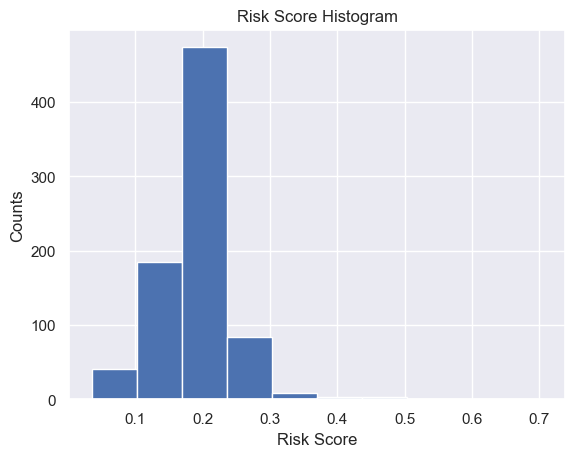

In [93]:
plt.hist(y)
plt.xlabel('Risk Score')
plt.ylabel('Counts')
plt.title('Risk Score Histogram')
plt.show()

In [94]:
import numpy as np

In [95]:
# https://medium.datadriveninvestor.com/introduction-31c985114aa1

In [96]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeRegressor
import shap
import numpy as np

# Define models
models = {
    'Linear Regression': LinearRegression(),
    # 'Random Forest Regression': RandomForestRegressor(),
    'XGBoost Regression': XGBRegressor(),
    # 'Decision Tree Regression': DecisionTreeRegressor(),
    # 'Gradient Boosting Regression': GradientBoostingRegressor(),
    # 'SVM Regression': SVR()
}

# Define parameter grids for hyperparameter tuning
param_grids = {
    'Random Forest Regression': {
        'n_estimators': [100, 200, 300],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5, 10]
    },
    'XGBoost Regression': {
        'n_estimators': np.arange(50, 200, 10),
        'learning_rate': np.linspace(0.005, 0.1, 25),
        'max_depth': np.arange(2, 12, 2),
        'subsample': np.linspace(0.5, 1, 6),
        'min_child_weight': np.arange(1, 10, 2),
        'gamma': np.linspace(0, 0.5, 5),
        'colsample_bytree': np.linspace(0.5, 1, 5)
    },
    'Gradient Boosting Regression': {
        'n_estimators': [100, 200, 300, 400],
        'learning_rate': [0.01, 0.1, 0.3],
        'max_depth': [3, 5, 7, 9]
    },
    'SVM Regression': {
        'C': [0.1, 1, 10],
        'gamma': ['scale', 'auto'],
        'kernel': ['linear', 'rbf']
    }
}
SEARCH_METHOD = 'random'
# Perform hyperparameter tuning and model training
predictions = {}
train_predictions = {}
best_models = {}
for model_name, model in models.items():
    if model_name in param_grids:
        if SEARCH_METHOD == 'grid':
            # Perform hyperparameter tuning
            grid_search = GridSearchCV(model, param_grids[model_name], cv=6, scoring='neg_mean_squared_error')
            pipeline = Pipeline([
                ('scaler', StandardScaler()),
                ('grid_search', grid_search)
            ])
        else:
            # Perform hyperparameter tuning using RandomizedSearchCV
            randomized_search = RandomizedSearchCV(model, param_grids[model_name], n_iter=500, cv=10, scoring='neg_mean_squared_error', random_state=42)
            pipeline = Pipeline([
                ('scaler', StandardScaler()),
                ('randomized_search', randomized_search)
            ])
    else:
        # No hyperparameter tuning for models without param grids
        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('model', model)
        ])
    
    pipeline.fit(X_train, y_train)
    y_train_pred = pipeline.predict(X_train)

    # Accessing the best validation score
    if SEARCH_METHOD == 'grid':
        best_validation_score = grid_search.best_score_
    else:
        best_validation_score = randomized_search.best_score_
    best_validation_mse = abs(best_validation_score)  # Convert to positive MSE
    
    print(f'{model_name} - Best Validation Mean Squared Error: {best_validation_mse}')

    # y_pred = pipeline.predict(X_test)
    # mse = mean_squared_error(y_test, y_pred)
    # print(f'{model_name} - Mean Squared Error: {mse}')
    # predictions[model_name] = y_pred
    train_predictions[model_name] = y_train_pred
    best_models[model_name] = pipeline

Linear Regression - Best Validation Mean Squared Error: 0.002259824304457014
XGBoost Regression - Best Validation Mean Squared Error: 0.002259824158788003


In [97]:
rsearch_df = pd.DataFrame(randomized_search.cv_results_)

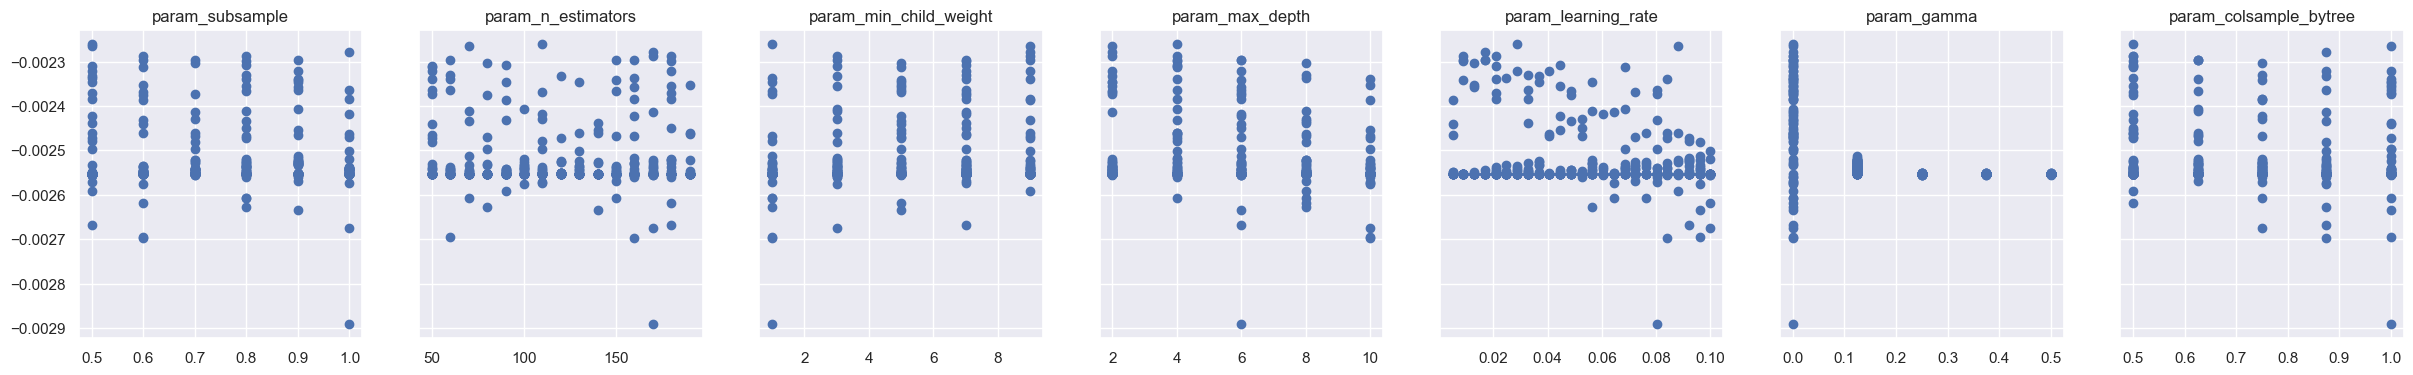

In [98]:
trial = 3
param_df = rsearch_df.filter(regex='param_')
num_params = param_df.shape[1]

fig, axes = plt.subplots(1, num_params, figsize=(30, 4), sharey=True)
for i, ax in enumerate(axes):
    ax.scatter(param_df.iloc[:, i], rsearch_df['mean_test_score'])
    ax.set_title(f'{param_df.columns[i]}')

fig.savefig(f'../figures/hp_tuning/xgboost_hp_correlations{trial}.png')


In [99]:
rsearch_df.sort_values(by='rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_subsample,param_n_estimators,param_min_child_weight,param_max_depth,param_learning_rate,param_gamma,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
112,0.058335,0.011682,0.000661,0.000070,0.5,110,1,4,0.02875,0.0,...,-0.001782,-0.001985,-0.005340,-0.001387,-0.001912,-0.002010,-0.001703,-0.002260,0.001120,1
387,0.026825,0.002347,0.000706,0.000183,0.5,70,9,2,0.088125,0.0,...,-0.001753,-0.002166,-0.005332,-0.001200,-0.002173,-0.002204,-0.001659,-0.002266,0.001121,2
119,0.039483,0.003477,0.000609,0.000036,1.0,170,9,2,0.016875,0.0,...,-0.001761,-0.002108,-0.005591,-0.001383,-0.002054,-0.001965,-0.001582,-0.002278,0.001199,3
465,0.038936,0.002603,0.000732,0.000174,0.8,170,9,2,0.020833,0.0,...,-0.001759,-0.002102,-0.005545,-0.001327,-0.002088,-0.002118,-0.001573,-0.002287,0.001187,4
298,0.080766,0.007930,0.000794,0.000159,0.6,180,3,4,0.008958,0.0,...,-0.001783,-0.002018,-0.005518,-0.001440,-0.001995,-0.001966,-0.001661,-0.002287,0.001176,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130,0.108035,0.013782,0.000849,0.000065,0.5,180,7,6,0.092083,0.0,...,-0.002076,-0.002316,-0.005840,-0.001781,-0.002270,-0.002470,-0.002045,-0.002669,0.001140,496
303,0.202772,0.015713,0.001026,0.000035,1.0,170,3,10,0.1,0.0,...,-0.002352,-0.002334,-0.005748,-0.001726,-0.002236,-0.002869,-0.001869,-0.002675,0.001146,497
37,0.124974,0.011910,0.000879,0.000128,0.6,60,1,10,0.096042,0.0,...,-0.002197,-0.002028,-0.005823,-0.001700,-0.002380,-0.002662,-0.001971,-0.002696,0.001166,498
481,0.243990,0.017594,0.001148,0.000171,0.6,160,1,10,0.084167,0.0,...,-0.002189,-0.002196,-0.005394,-0.001745,-0.002570,-0.003024,-0.001903,-0.002698,0.001051,499


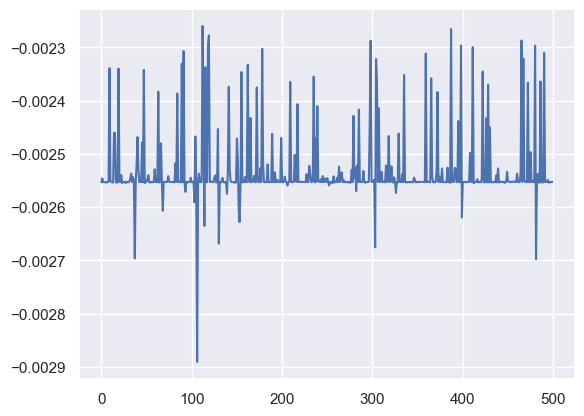

In [100]:
plt.plot(rsearch_df.mean_test_score)

In [101]:
best_models['XGBoost Regression'].named_steps['randomized_search'].best_estimator_

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.5, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.0, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.02875, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=4, max_leaves=None,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=110, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

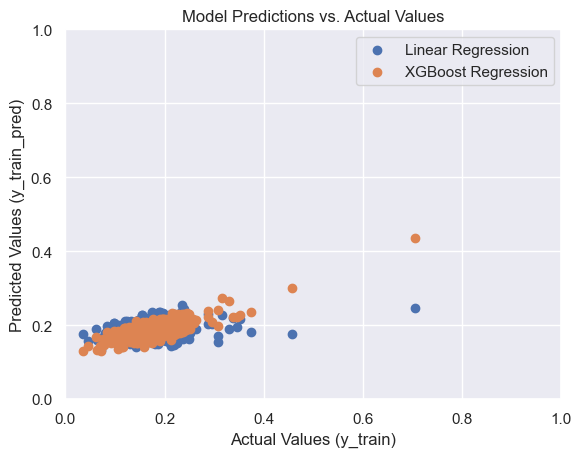

In [102]:
for model_name, y_train_pred in train_predictions.items():
    plt.scatter(y_train, y_train_pred, label=model_name)

plt.xlabel('Actual Values (y_train)')
plt.ylabel('Predicted Values (y_train_pred)')
plt.title('Model Predictions vs. Actual Values')
plt.legend()
plt.grid(True)
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


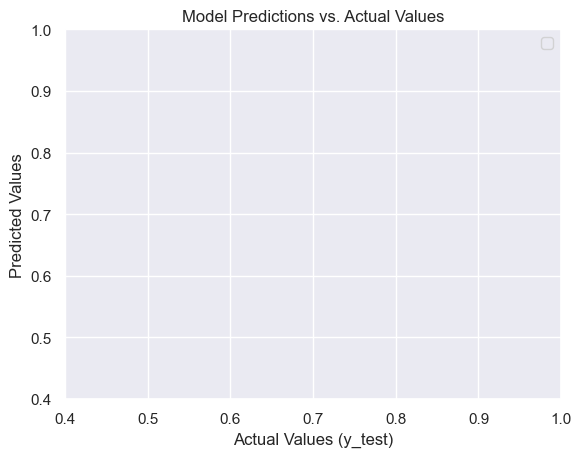

In [104]:
for model_name, y_pred in predictions.items():
    plt.scatter(y_test, y_pred, label=model_name)

plt.xlabel('Actual Values (y_test)')
plt.ylabel('Predicted Values')
plt.title('Model Predictions vs. Actual Values')
plt.xlim(0.4, 1)
plt.ylim(0.4, 1)
plt.legend()
plt.grid(True)
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


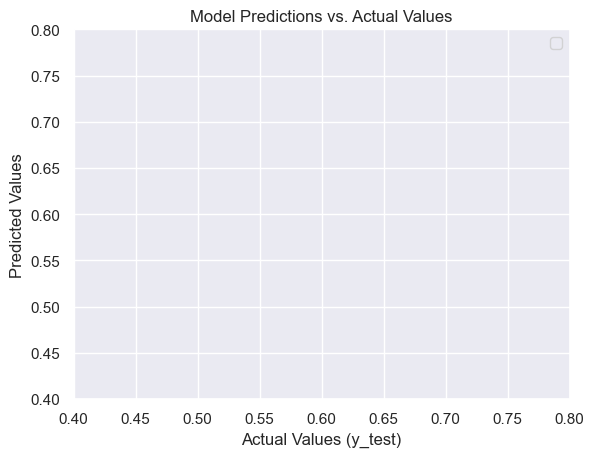

In [105]:
for model_name, y_pred in predictions.items():
    if model_name in ['XGBoost Regression', 'Gradient Boosting Regression', 'SVM Regression']:
        plt.scatter(y_test, y_pred, label=model_name)

plt.xlabel('Actual Values (y_test)')
plt.ylabel('Predicted Values')
plt.title('Model Predictions vs. Actual Values')
plt.legend()
plt.grid(True)
plt.xlim([0.4, 0.8])
plt.ylim([0.4, 0.8])
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


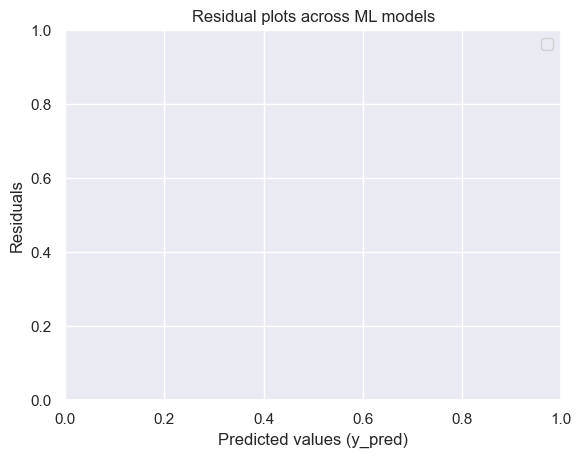

In [106]:
for model_name, y_pred in predictions.items():
    if model_name not in []:
        plt.scatter(y_pred, y_test - y_pred, label=model_name)

plt.xlabel('Predicted values (y_pred)')
plt.ylabel('Residuals')
plt.title('Residual plots across ML models')
plt.legend()
plt.grid(True)
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


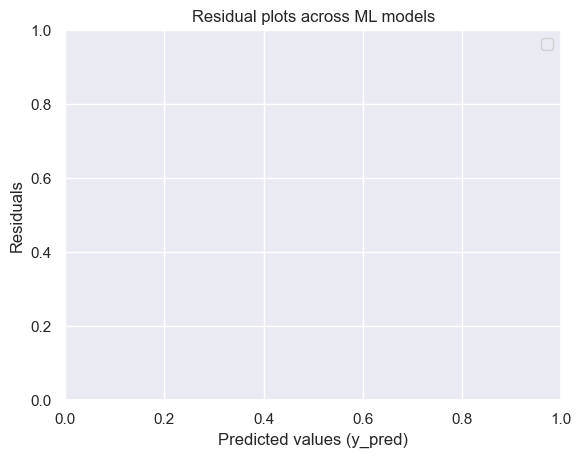

In [107]:
for model_name, y_pred in predictions.items():
    if model_name in ['Linear Regression', 'Random Forest Regression']:
        plt.scatter(y_pred, y_test - y_pred, label=model_name)

plt.xlabel('Predicted values (y_pred)')
plt.ylabel('Residuals')
plt.title('Residual plots across ML models')
plt.legend()
plt.grid(True)
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


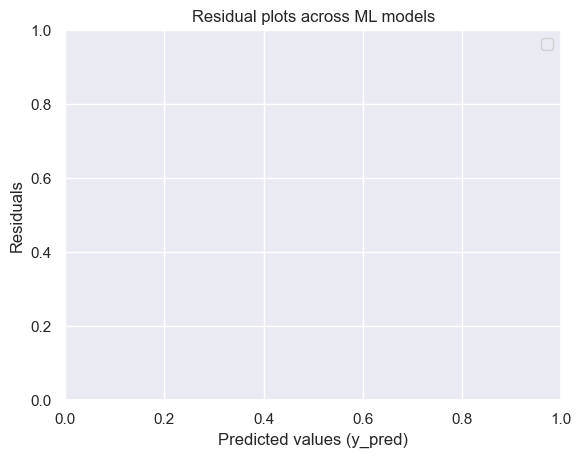

In [108]:
for model_name, y_pred in predictions.items():
    if model_name in ['XGBoost Regression', 'Gradient Boosting Regression', 'SVM Regression']:
        plt.scatter(y_pred, y_test - y_pred, label=model_name)

plt.xlabel('Predicted values (y_pred)')
plt.ylabel('Residuals')
plt.title('Residual plots across ML models')
plt.legend()
plt.grid(True)
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


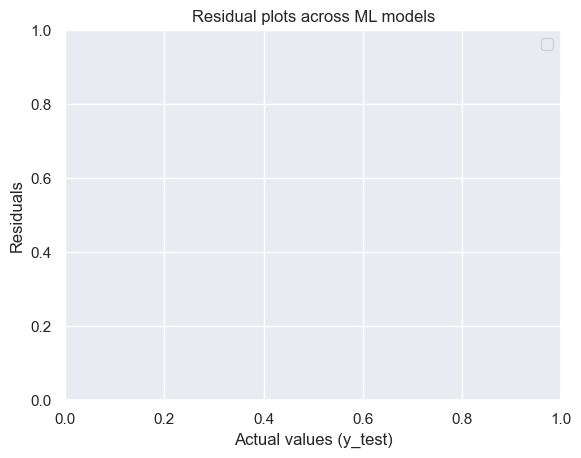

In [109]:
for model_name, y_pred in predictions.items():
    if model_name in ['XGBoost Regression', 'Gradient Boosting Regression', 'SVM Regression']:
        plt.scatter(y_test, y_test - y_pred, label=model_name)

plt.xlabel('Actual values (y_test)')
plt.ylabel('Residuals')
plt.title('Residual plots across ML models')
plt.legend()
plt.grid(True)
plt.show()

In [110]:
best_models['Linear Regression'].get_params

<bound method Pipeline.get_params of Pipeline(steps=[('scaler', StandardScaler()), ('model', LinearRegression())])>

In [111]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

def plot_learning_curves(model, X, y):
    train_sizes, train_scores, valid_scores = learning_curve(
        model, X, y, train_sizes=np.linspace(0.1, 1.0, 10),
        scoring='neg_mean_squared_error', cv=5)
    
    train_scores_mean = -np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    valid_scores_mean = -np.mean(valid_scores, axis=1)
    valid_scores_std = np.std(valid_scores, axis=1)
    
    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_scores_mean, label='Training error', color='blue')
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color='blue')
    plt.plot(train_sizes, valid_scores_mean, label='Validation error', color='orange')
    plt.fill_between(train_sizes, valid_scores_mean - valid_scores_std,
                     valid_scores_mean + valid_scores_std, alpha=0.1, color='orange')
    
    plt.xlabel('Training examples')
    plt.ylabel('Mean Squared Error')
    plt.title('Learning Curves')
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()


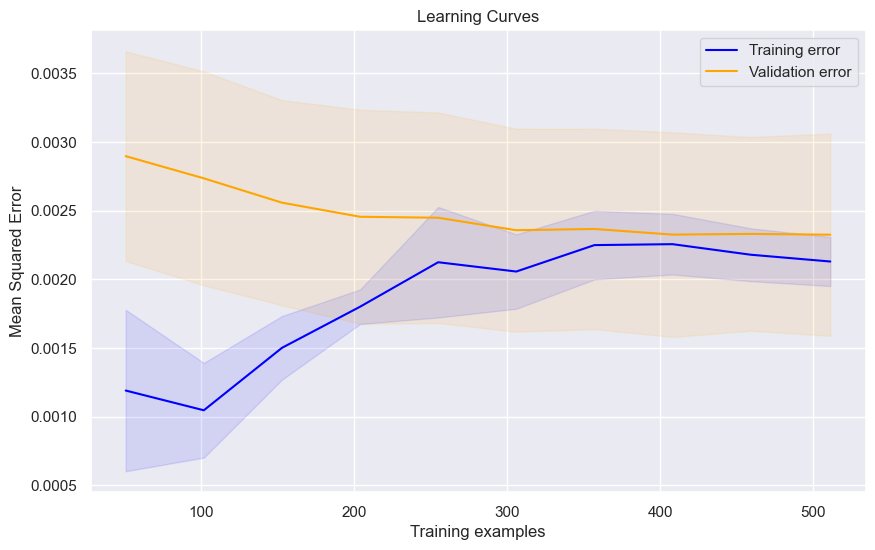

In [112]:
# Assuming you have your X_train and y_train ready
# Let's visualize learning curves for one of your models, for example, RandomForestRegressor
model = LinearRegression()
plot_learning_curves(model, X_train, y_train)

In [113]:
best_models['Random Forest Regression'].named_steps['grid_search'].best_estimator_

KeyError: 'Random Forest Regression'

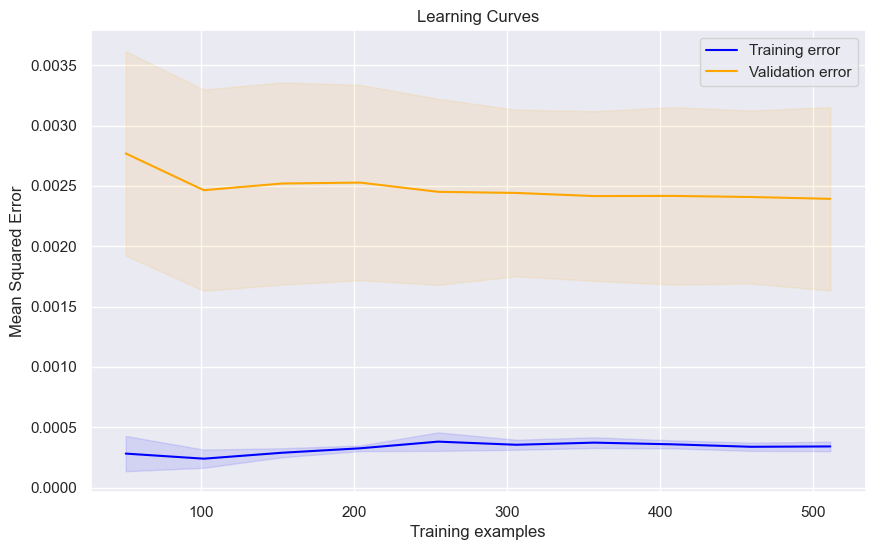

In [114]:
model = RandomForestRegressor(max_depth=20, n_estimators=300)
plot_learning_curves(model, X_train, y_train)

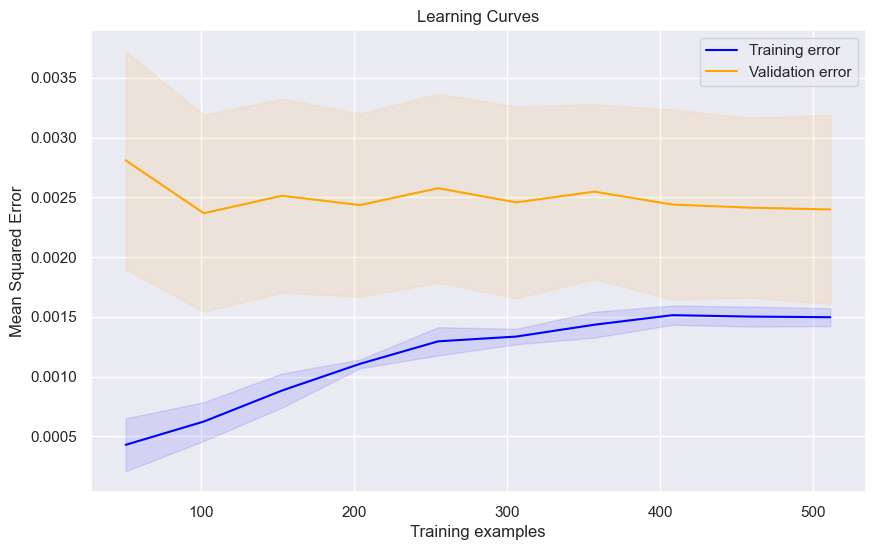

In [115]:
model = XGBRegressor(max_depth=3, learning_rate=0.01, n_estimators=200)
plot_learning_curves(model, X_train, y_train)

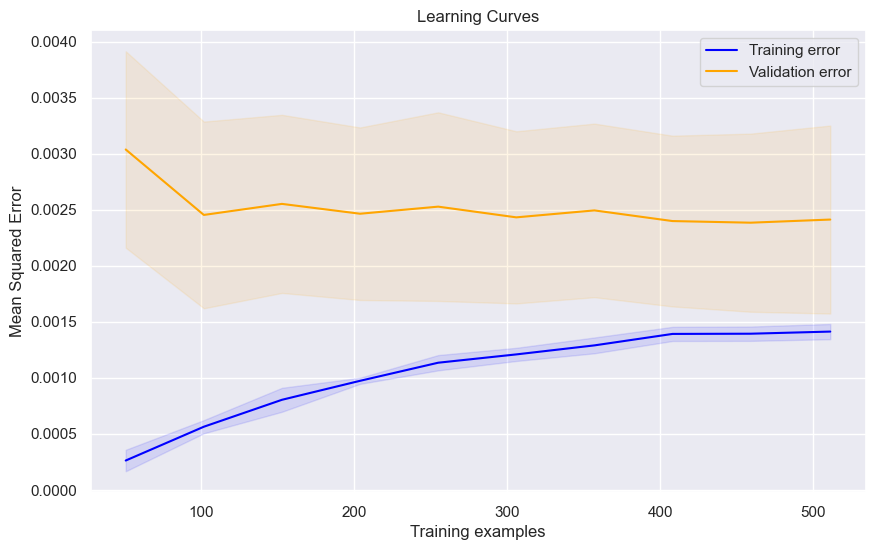

In [116]:
model = GradientBoostingRegressor(learning_rate=0.01, n_estimators=200)
plot_learning_curves(model, X_train, y_train)

In [117]:
best_models['Gradient Boosting Regression'].named_steps['grid_search'].best_estimator_

KeyError: 'Gradient Boosting Regression'